In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.timeseries import LombScargle
import scipy.signal as signal
from scipy import optimize
import matplotlib.gridspec as gridspec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


Making a cyberpunk tess plot

In [3]:
tessfits = glob.glob('tess_fits_files/*fits')
tessfits

['tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits',
 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits']

In [4]:
s15fits = 'tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits'
s16fits = 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits'

In [8]:
fitter = fitting.LevMarLSQFitter()

for i, ft in enumerate(tessfits):
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
    fit = np.polyval((np.polyfit(t,f,2)), t)
    f = (f/fit)-1
    e = (e/fit)
    lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
    if i == 0:
        lc15 = lc
    else:
        lc16= lc

In [16]:
import mplcyberpunk
plt.style.use("cyberpunk")

446
1724.9522817263553


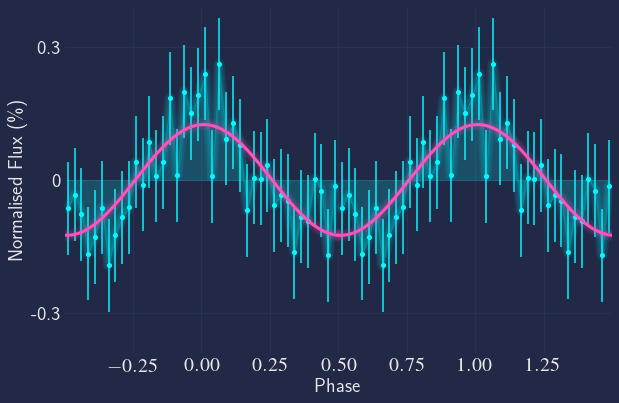

In [38]:
periods = []
period_errors = []
amplitudes = []
amplitude_errors = []

orb_split = [1724.5, 1751 ] #tae to get the pericenters
sectors = [15, 16]
plt.figure(figsize=(9, 6))

    
lc = lc15
pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)


sin_mod =  models.Sine1D(amplitude=0.01, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})
sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#plt.axvline(orb_split[i])



pbin =int(len(lc.time)/40)
print(pbin)

t0 = lc.time[0]#+(sin_fit.phase*sin_fit.frequency) #what phase to fold to


mid = lc.time[0]+ 0.5 * (lc.time[-1]-lc.time[0])
tep = np.linspace(mid-0.599, mid+0.99, 10000)
# plt.plot(tep, sin_fit(tep))
eph = tep[np.argmax(sin_fit(tep))]# +2457000
print(eph)

lc_fold = lc.fold(1/sin_fit.frequency,  t0 =eph)#, t0 = t0)#.bin(50)
#lc_fold = lc.fold(1/sin_fit.frequency, t0 = 0)#.bin(50)
# lc_fold = lc.fold(1.1468045290740154, t0 = 0)#.bin(50)
#plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none', marker='o', ms=4, c='C0')
plt.errorbar(lc_fold.bin(pbin).time+1, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none', marker='o', ms=4, c='C0')

plt.plot(lc_fold.bin(pbin).time+1, lc_fold.bin(pbin).flux, c='C0', alpha=0)
plt.plot(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, c='C0', alpha=0)

#mplcyberpunk.add_glow_effects()
mplcyberpunk.add_underglow()
#plt.scatter(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux,  s=10, c='C0')
#plt.scatter(lc_fold.bin(pbin).time+1, lc_fold.bin(pbin).flux, s=10, c='C0')

fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
#fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#fold_fit = models.Sine1D(amplitude=sin_fit.amplitude, frequency=1, phase=sin_fit.phase)
plt.plot(lc_fold.time,fold_fit(lc_fold.time), c='C1', lw=3, zorder=10)
plt.plot(lc_fold.time+1,fold_fit(lc_fold.time), c='C1', lw=3, zorder=10) 
#  plt.errorbar(1.5, 0.003, yerr=np.median(lc_fold.bin(pbin).flux_err))

plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Phase', size=20)
plt.ylim(-0.0039, 0.0039)
plt.yticks((-0.003, 0, 0.003), ('-0.3', '0', '0.3'))
plt.xlim(-0.499, 1.499)

#  print(sin_fit)


# print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
# print('Adjusted Amplitide (folded)', fold_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)


mplcyberpunk.make_lines_glow()


plt.tight_layout()
#plt.subplots_adjust(hspace=0.2, wspace=0.2)

#plt.savefig('plots/gd394_tess_full.pdf', dpi=150)
plt.savefig('plots/gd394_tess_cp.png', dpi=150)
